In [1]:
import util.utils as utils

percentage = 0.02
rand_seed = 42
data_sampling_freq = '10s'
rolling_window_size = '10s'

df_result = utils.get_binary(percentage, rand_seed)
df_audio = utils.get_audio(percentage, rand_seed, data_sampling_freq, rolling_window_size)

display(df_audio)
display(df_result)

# TODO: consider possible addisional extracted features:
#   Vowel triangle, Jitter, Shimmer, HNR

AUDIO_AMPLITUDE  FORMANT_F1   FORMANT_F2   FORMANT_F3  \
ID  TIMESTAMP                                                                
386 0 days 00:00:00        -0.000004  614.645050  1569.856156  2555.688481   
    0 days 00:00:10        -0.000022  723.162229  1729.766756  2606.151056   
    0 days 00:00:20        -0.000004  612.055450  1654.936994  2564.859750   
    0 days 00:00:30        -0.000016  536.626819  1658.906150  2599.293833   
    0 days 00:00:40        -0.000023  470.114869  1632.436436  2606.598722   
...                              ...         ...          ...          ...   
391 0 days 00:10:40        -0.000037  601.069346  1592.053147  2508.186500   
    0 days 00:10:50        -0.000004  758.848328  1704.821917  2577.518944   
    0 days 00:11:00        -0.000042  827.604836  1755.064408  2635.432333   
    0 days 00:11:10         0.000012  758.418220  1721.411781  2655.801250   
    0 days 00:11:20         0.000039  380.222222  1583.388889  2353.888889   

                      FORMANT_F4   FORMANT_F5  COVAREP_F0  COVAREP_VUV  \
ID  TIMESTAMP                                                            
386 0 days 00:00:00  3448.281500  4355.226917  244.852083     0.135556   
    0 days 00:00:10  3481.564889  4401.983833  250.858750     0.044167   
    0 days 00:00:20  3452.678694  4339.918194  248.480833     0.446944   
    0 days 00:00:30  3510.076361  4367.084278  234.161667     0.433056   
    0 days 00:00:40  3513.154611  4338.591056  220.591250     0.512778   
...                          ...          ...         ...          ...   
391 0 days 00:10:40  3406.220000  4326.081000  254.759028     0.341944   
    0 days 00:10:50  3480.200111  4356.791861  271.011250     0.148611   
    0 days 00:11:00  3491.444111  4389.154861  274.051389     0.044167   
    0 days 00:11:10  3507.398111  4381.977750  272.903333     0.209167   
    0 days 00:11:20  3300.444444  4439.611111   73.000000     0.000000   

                     COVAREP_NAQ  COVAREP_QOQ  ...  COVAREP_HMPDD_3  \
ID  TIMESTAMP                                  ...                    
386 0 days 00:00:00     0.056976     0.150301  ...        -1.064362   
    0 days 00:00:10     0.042157     0.103817  ...        -1.052944   
    0 days 00:00:20     0.058107     0.177877  ...        -1.153529   
    0 days 00:00:30     0.057946     0.173296  ...        -1.110738   
    0 days 00:00:40     0.061950     0.199593  ...        -1.129264   
...                          ...          ...  ...              ...   
391 0 days 00:10:40     0.065125     0.221965  ...        -1.160749   
    0 days 00:10:50     0.037315     0.155814  ...        -1.129113   
    0 days 00:11:00     0.020857     0.069702  ...        -1.142678   
    0 days 00:11:10     0.049178     0.140093  ...        -1.189404   
    0 days 00:11:20     0.000000     0.000000  ...        -0.116297   

                     COVAREP_HMPDD_4  COVAREP_HMPDD_5  COVAREP_HMPDD_6  \
ID  TIMESTAMP                                                            
386 0 days 00:00:00        -0.912175        -0.759586        -0.614320   
    0 days 00:00:10        -0.925264        -0.766965        -0.607162   
    0 days 00:00:20        -0.958603        -0.744215        -0.546716   
    0 days 00:00:30        -0.951310        -0.752610        -0.588919   
    0 days 00:00:40        -0.958322        -0.773844        -0.608530   
...                              ...              ...              ...   
391 0 days 00:10:40        -0.953898        -0.753846        -0.576185   
    0 days 00:10:50        -0.934019        -0.743022        -0.564444   
    0 days 00:11:00        -0.958067        -0.770274        -0.606131   
    0 days 00:11:10        -0.987858        -0.776655        -0.579951   
    0 days 00:11:20        -0.052773        -0.076418        -0.097877   

                     COVAREP_HMPDD_7  COVAREP_HMPDD_8  COVAREP_HMPDD_9  \
ID  TIMESTAMP                                                            
386 0 da

,PHQ_Binary
ID,
386,1
391,0


### EDA

* functional frequency / energy distribution
* MFCC
* speed of speech (if available)

Basic statistics for audio features:
       AUDIO_AMPLITUDE  FORMANT_F1   FORMANT_F2   FORMANT_F3   FORMANT_F4  \
count       173.000000  173.000000   173.000000   173.000000   173.000000   
mean         -0.000024  600.364694  1609.524260  2544.139459  3446.730031   
std           0.000021   58.174944    48.554234    47.716262    43.933167   
min          -0.000229  380.222222  1451.548358  2330.177414  3229.739861   
25%          -0.000029  566.106303  1580.383983  2515.663511  3420.014611   
50%          -0.000022  595.262664  1605.985586  2548.579306  3445.620722   
75%          -0.000015  627.448308  1641.099153  2574.231211  3477.433389   
max           0.000039  827.604836  1781.254525  2655.801250  3541.012833   

        FORMANT_F5  COVAREP_F0  COVAREP_VUV  COVAREP_NAQ  COVAREP_QOQ  ...  \
count   173.000000  173.000000   173.000000   173.000000   173.000000  ...   
mean   4323.659388  226.006064     0.428605     0.058386     0.191565  ...   
std      46.000039   26.049009     

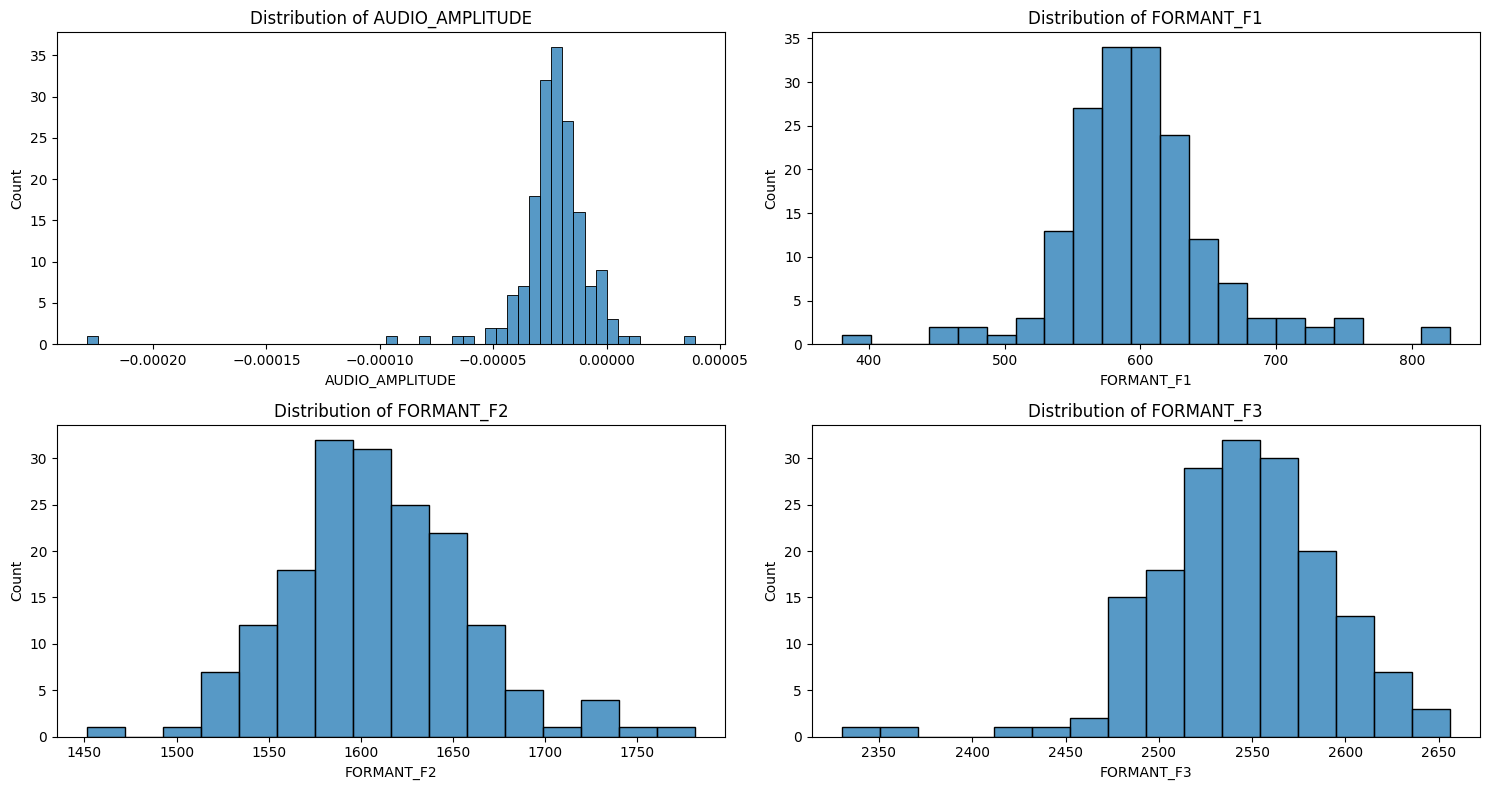

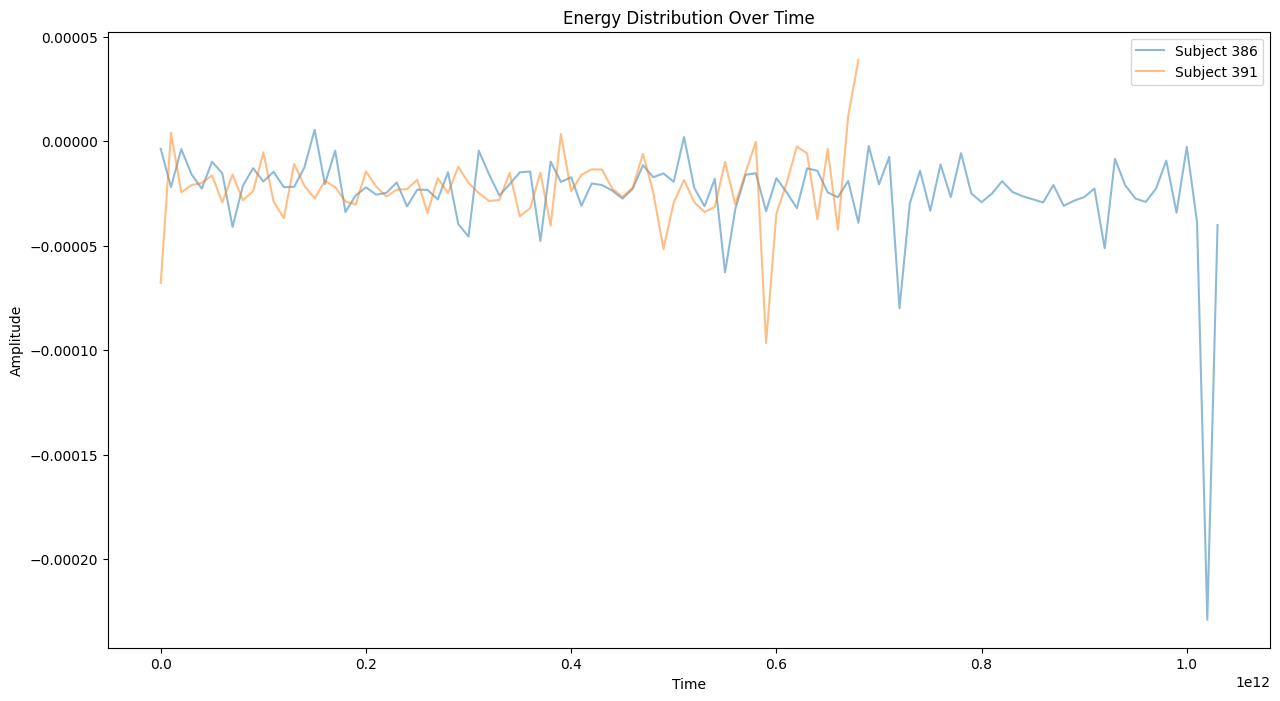

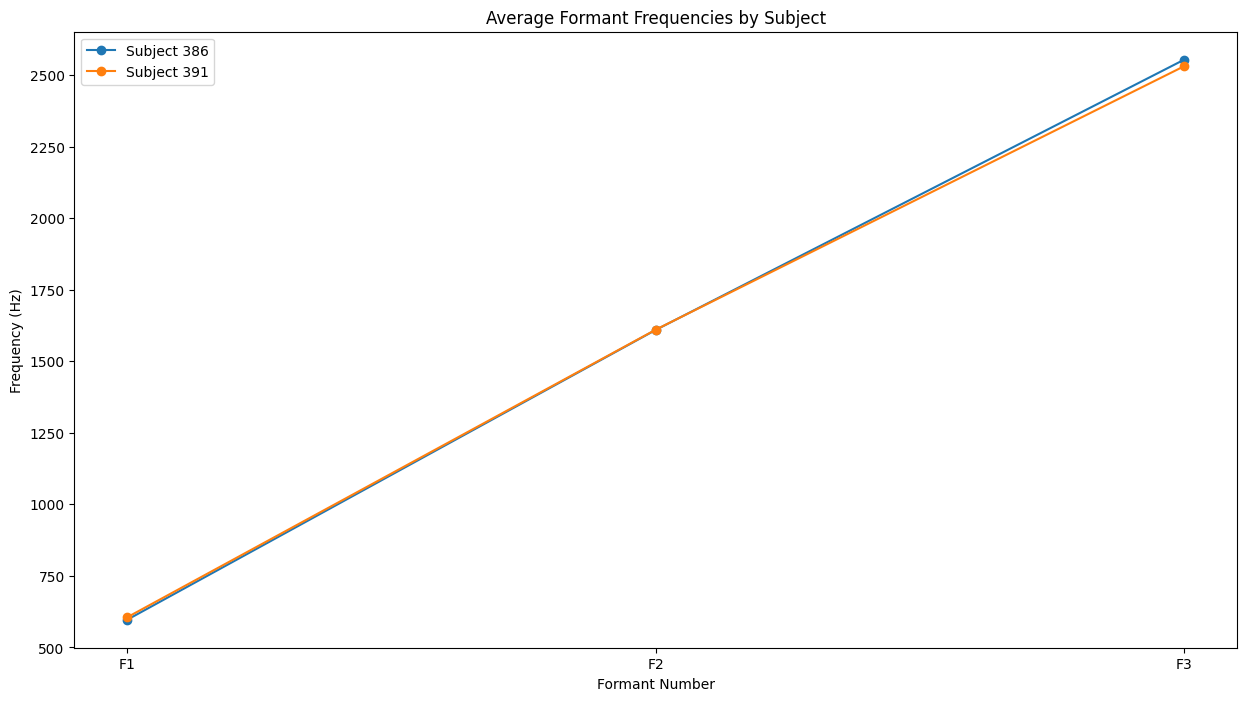

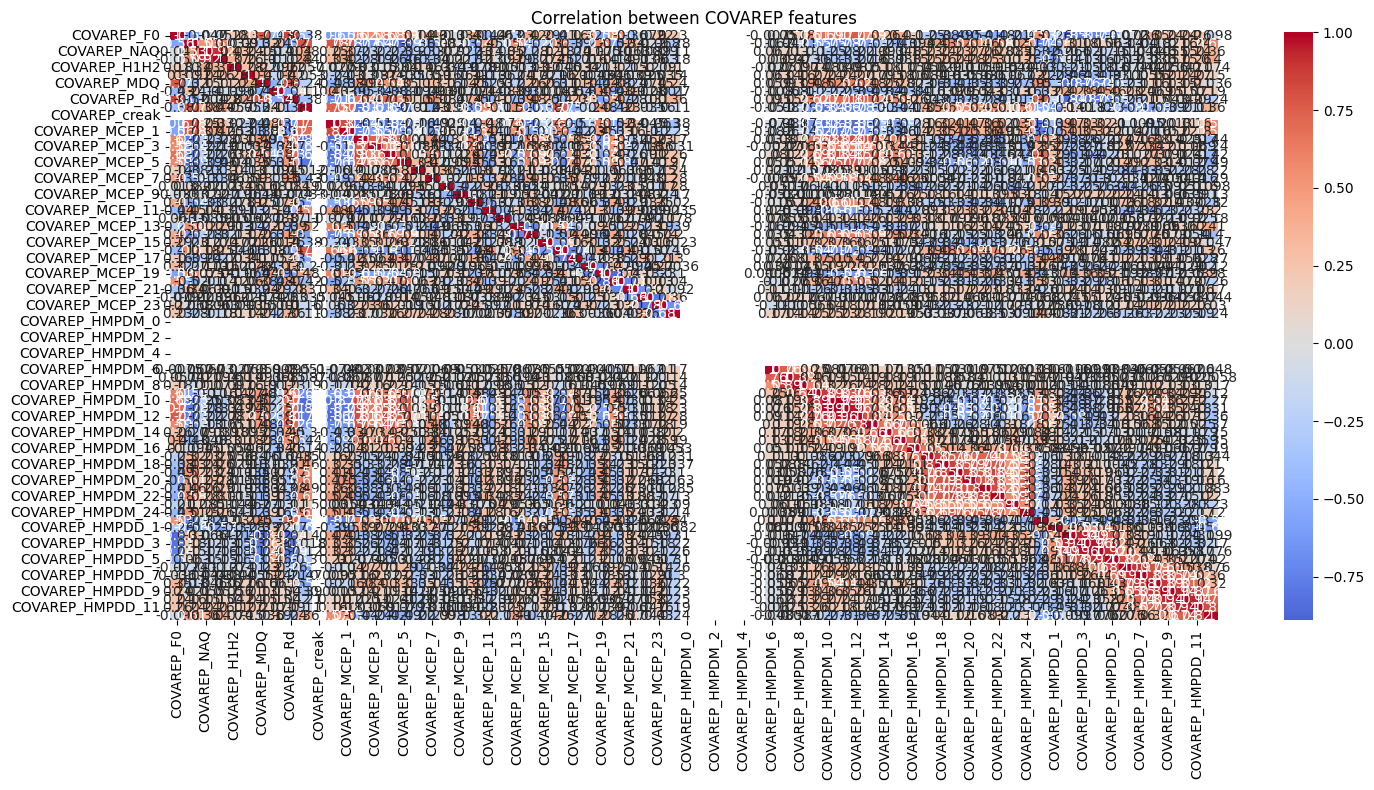

Subject 386 approximate speech activity rate: 0.0385
Subject 391 approximate speech activity rate: 0.0725


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
# plt.style.use('seaborn')
fig_size = (15, 8)

# Basic statistics for audio features
print("Basic statistics for audio features:")
print(df_audio.describe())

# Plot distributions of key audio features
audio_features = ['AUDIO_AMPLITUDE', 'FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']

fig, axes = plt.subplots(2, 2, figsize=fig_size)
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    sns.histplot(data=df_audio[feature], ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
plt.tight_layout()
plt.show()

# Energy distribution over time
plt.figure(figsize=fig_size)
for id in df_audio.index.get_level_values('ID').unique():
    plt.plot(df_audio.loc[id]['AUDIO_AMPLITUDE'], 
             alpha=0.5, 
             label=f'Subject {id}')
plt.title('Energy Distribution Over Time')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Formant frequencies analysis
plt.figure(figsize=fig_size)
formant_features = ['FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']
for id in df_audio.index.get_level_values('ID').unique():
    subject_data = df_audio.loc[id][formant_features]
    plt.plot(subject_data.mean(), 'o-', label=f'Subject {id}')
plt.title('Average Formant Frequencies by Subject')
plt.xlabel('Formant Number')
plt.ylabel('Frequency (Hz)')
plt.xticks([0, 1, 2], ['F1', 'F2', 'F3'])
plt.legend()
plt.show()

# COVAREP features analysis
covarep_cols = [col for col in df_audio.columns if 'COVAREP' in col]
if len(covarep_cols) > 0:
    plt.figure(figsize=fig_size)
    sns.heatmap(df_audio[covarep_cols].corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0)
    plt.title('Correlation between COVAREP features')
    plt.tight_layout()
    plt.show()

# Speech rate analysis (using amplitude changes as proxy)
for id in df_audio.index.get_level_values('ID').unique():
    subject_data = df_audio.loc[id]['AUDIO_AMPLITUDE']
    # Calculate zero crossings as a rough measure of speech activity
    zero_crossings = np.where(np.diff(np.signbit(subject_data)))[0]
    speech_rate = len(zero_crossings) / len(subject_data)
    print(f"Subject {id} approximate speech activity rate: {speech_rate:.4f}")

### PCA

In [ ]:

from sklearn.decomposition import PCA

# First, let's prepare the data
# Select numerical features from df_audio (excluding the target variable)
X = df_audio.select_dtypes(include=['float64', 'int64'])

# Initialize and fit PCA
# You can adjust n_components as needed
pca = PCA(n_components=10)  # Start with 10 components
X_pca = pca.fit_transform(X)

# Plot explained variance ratio
plt.figure(figsize=fig_size)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=X.index
)

# Plot first two principal components
plt.figure(figsize=fig_size)
for id in pca_df.index.get_level_values('ID').unique():
    mask = pca_df.index.get_level_values('ID') == id
    plt.scatter(pca_df[mask]['PC1'], 
                pca_df[mask]['PC2'], 
                alpha=0.6,
                label=f'Subject {id}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance ratio for each component
print("\nExplained variance ratio for each component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

# Print cumulative explained variance ratio
print("\nCumulative explained variance ratio:")
print(np.cumsum(pca.explained_variance_ratio_))

# Get feature importance
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=X.columns
)

# Plot heatmap of feature importance for first few components
plt.figure(figsize=fig_size)
sns.heatmap(feature_importance.iloc[:, :5], 
            cmap='coolwarm', 
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Feature Importance in First 5 Principal Components')
plt.tight_layout()
plt.show()

### train test split

In [ ]:
# merge TODO: make sure to use the PCA df
df = pd.merge(df_audio, df_result, on='ID')

from sklearn.model_selection import TimeSeriesSplit

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Prepare X and y
X = df.drop(['PHQ_Binary'], axis=1)
y = df['PHQ_Binary']

# Initialize lists to store the split indices
train_indices = []
test_indices = []

# Get split indices while preserving the temporal order
for train_idx, test_idx in tscv.split(X):
    train_indices.append(train_idx)
    test_indices.append(test_idx)

# Use the last fold for final train/test split
X_train = X.iloc[train_indices[-1]]
X_test = X.iloc[test_indices[-1]]
y_train = y.iloc[train_indices[-1]]
y_test = y.iloc[test_indices[-1]]

# Further split training data into train and validation
train_size = int(0.75 * len(X_train))
X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### pipeline & hyperparameter tuning

In [ ]:
### Pipeline & Hyperparameter Tuning

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train.values)
y_val_tensor = torch.LongTensor(y_val.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the RNN model
class AudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(AudioRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_size, 1)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 2)  # 2 classes for binary classification
        
    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Apply attention
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Final classification layers
        out = self.dropout(torch.relu(self.fc1(context_vector)))
        out = self.fc2(out)
        return out

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model = model.to(device)
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5
    
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

# Hyperparameter grid
param_grid = {
    'hidden_size': [64, 128],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.0001],
}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Grid search
best_val_loss = float('inf')
best_params = None
results = []

for params in tqdm(ParameterGrid(param_grid)):
    # Model initialization
    model = AudioRNN(
        input_size=X_train.shape[1],
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Train the model
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        n_epochs=50,
        device=device
    )
    
    # Record results
    final_val_loss = val_losses[-1]
    results.append({
        'params': params,
        'final_val_loss': final_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    })
    
    # Update best parameters
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = params

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=fig_size)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### evaluation  

In [12]:
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# 
# y_pred = grid_search.predict(X_test)
# 
# y_test = y_test.to_numpy()
# # Debug: Check the shapes and types of y_pred
# print(f'y_pred: {y_pred}')
# print(f'y_test: {y_test}')
# 
# # Generate and display classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# 
# # Generate and display confusion matrix
# cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
# disp.plot(cmap=plt.cm.Blues)
# plt.show()
# 
